# Resimulat MDL tests

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from vessel_manoeuvring_models.models.wind_force import WindForceSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm
from wPCC_pipeline.pipelines.vct_data.nodes import vct_scaling
from vct.bokeh_plotting import create_tab

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

Loading BokehJS ...

In [3]:
%reload_kedro
ship='wPCC'
df_VCT = catalog.load(f"{ship}.df_VCT")
ship_data = catalog.load(f"{ship}.ship_data")
model_loaders = catalog.load(f"{ship}.models")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
data_source_name = "MDL"
models = [
#"vct",
"VCT_MDL_resistance",
#"VCT_MDL_resistance_optimized_kappa",
"MDL_hull_inverse_dynamics",
"MDL_inverse_dynamics"
]
vmms = [
"vmm_simple",
"vmm_7m_vct",
#"vmm_martins_simple",
#"vmm_martins_simple_thrust",
]

resimulates={}
for vmm in vmms:
    for model_name in models:
        name = f"{vmm}.{model_name}"
        try:
            resimulates[name] = catalog.load(f"{ ship }.{ data_source_name }.{vmm}.{ model_name }.resimulate")
        except:
            continue

[07/20/23 16:55:43] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=572671;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=771244;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/20/23 16:55:54] INFO     Kedro project phd                                                      ]8;id=595835;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=154466;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=192836;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=355956;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=27390;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=154293;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=470276;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=146113;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=941762;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=178870;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=573525;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=826302;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=746750;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=697891;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=296220;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=25970;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_simple.VCT_MDL_resistance.resimulate'                                   
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=136838;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=381703;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_simple.MDL_hull_inverse_dynamics.resimulate'                            
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=483948;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=356780;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_simple.MDL_inverse_dynamics.resimulate'                                 
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=379975;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=544407;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_7m_vct.VCT_MDL_resistance.resimulate'                                   
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=933840;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=242176;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_7m_vct.MDL_hull_inverse_dynamics.resimulate'                            
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from                                                  ]8;id=979256;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=501412;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             'wPCC.MDL.vmm_7m_vct.MDL_inverse_dynamics.resimulate'                                 
                             (PartitionedDataSet)...                                                               

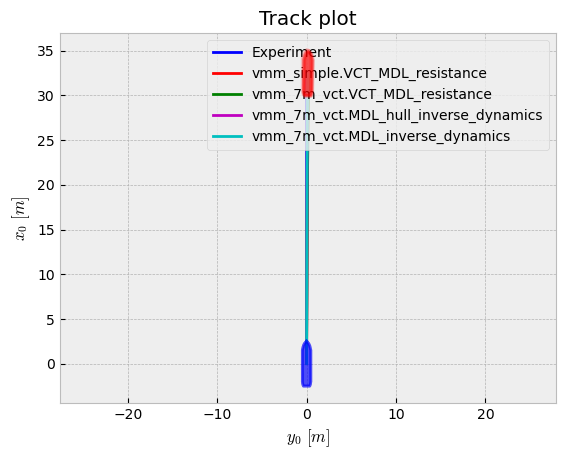

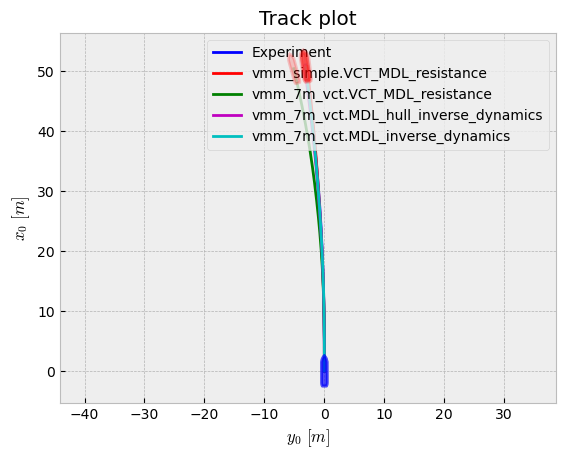

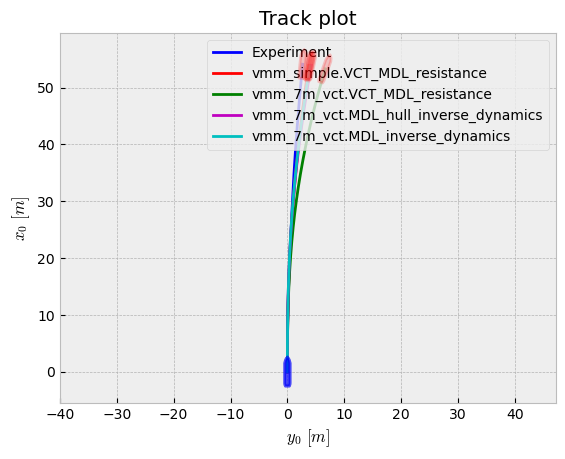

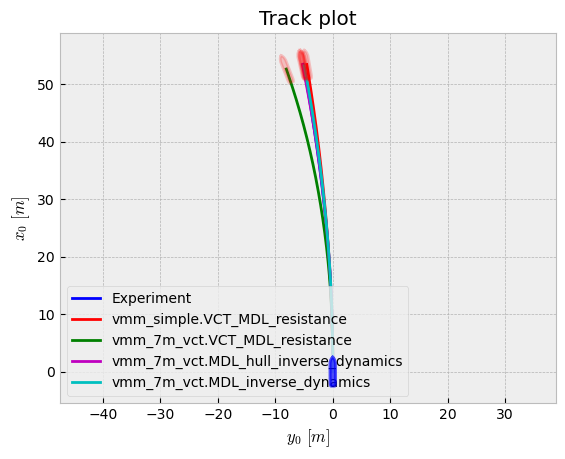

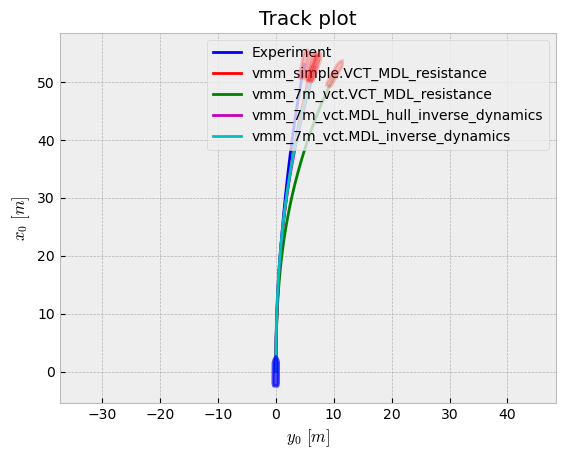

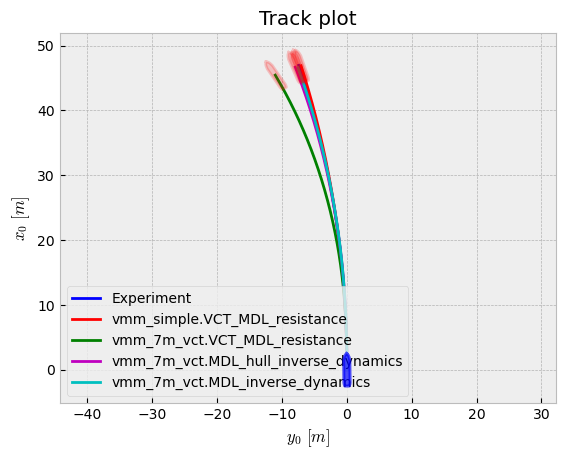

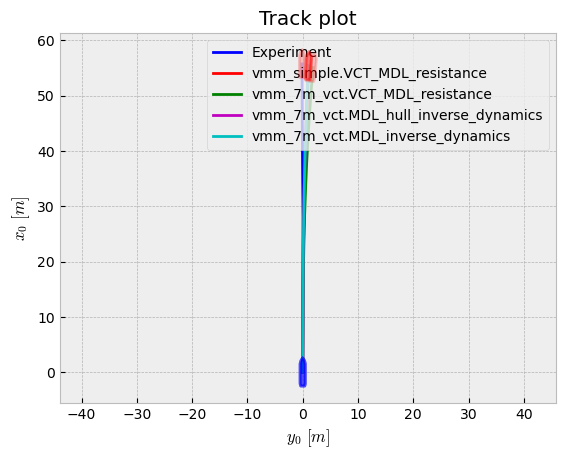

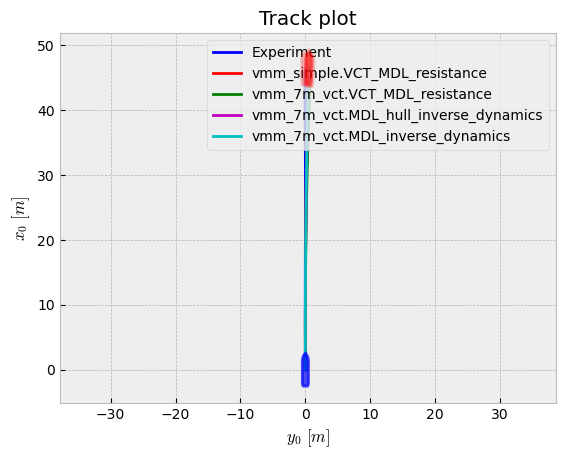

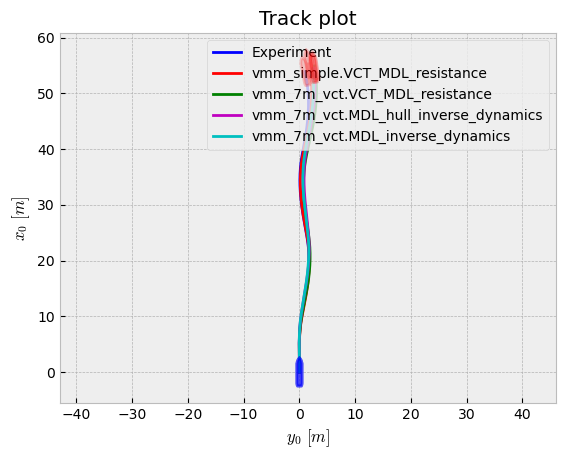

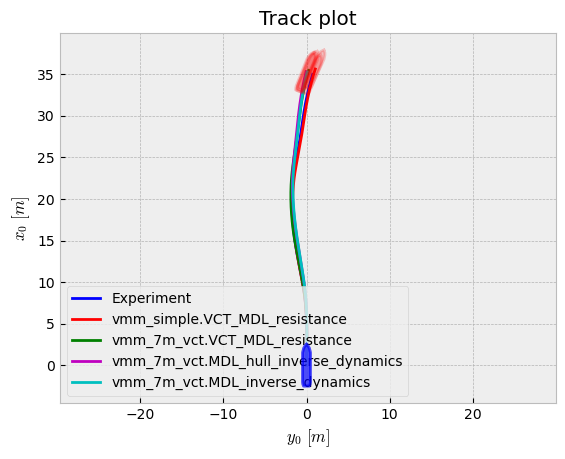

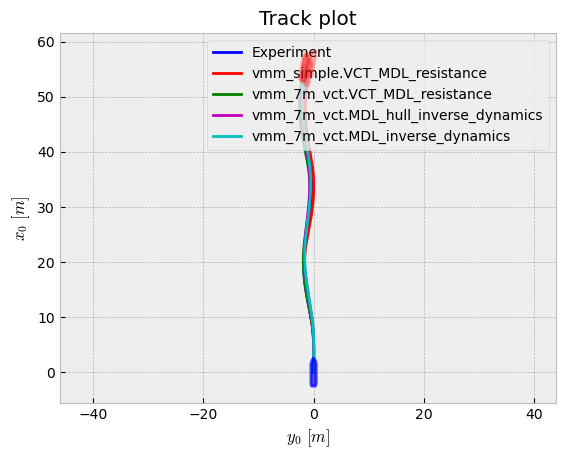

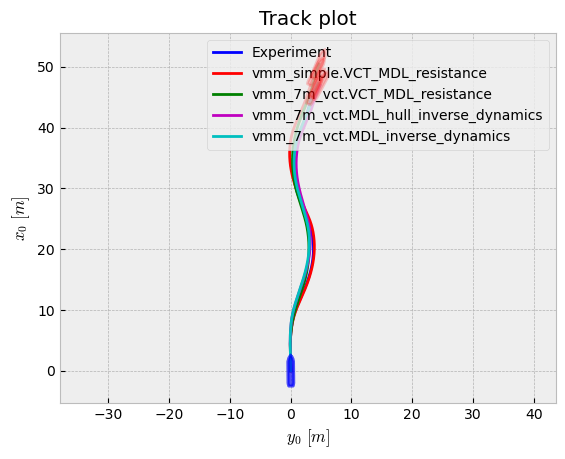

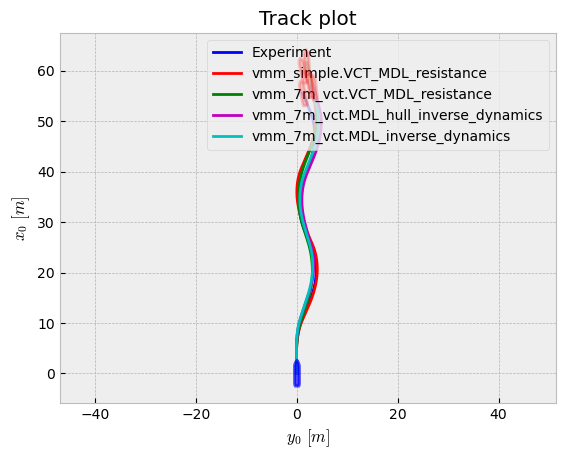

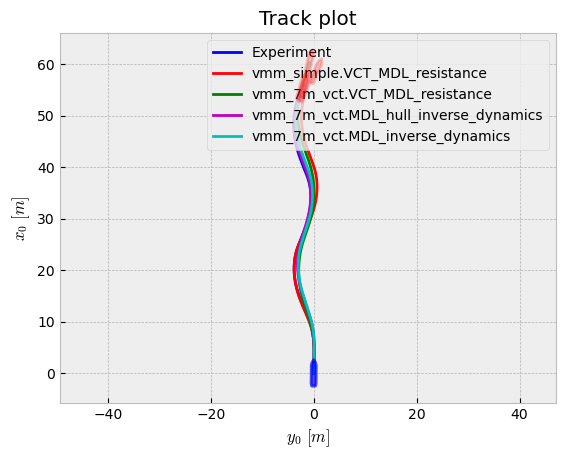

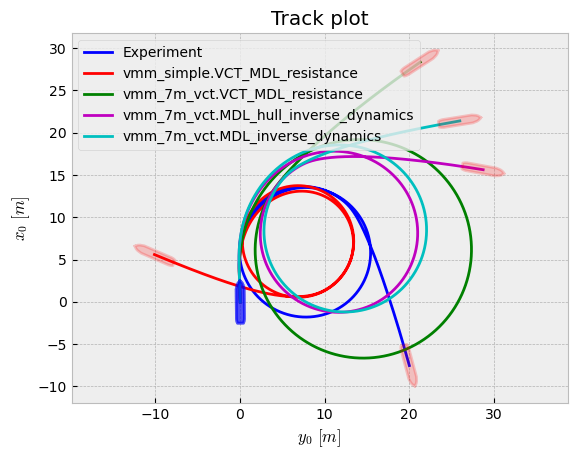

In [4]:
for key in time_series_smooth.keys():
    
    dataframes_ = {}
    found_simulation=False
    for model_name, resimulate_loaders in resimulates.items():
        if key in resimulate_loaders:
            dataframes_[model_name] = resimulate_loaders[key]()
            found_simulation=True
            
    if not found_simulation:
        continue
    
    data = time_series_smooth[key]()
    data['beta'] = -np.arctan2(data['v'],data['u'])
    dataframes = {
              'Experiment':data,
             }
    dataframes.update(dataframes_)
    
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=2)
    #plot(dataframes, keys=['u','v','r','beta','thrust']);

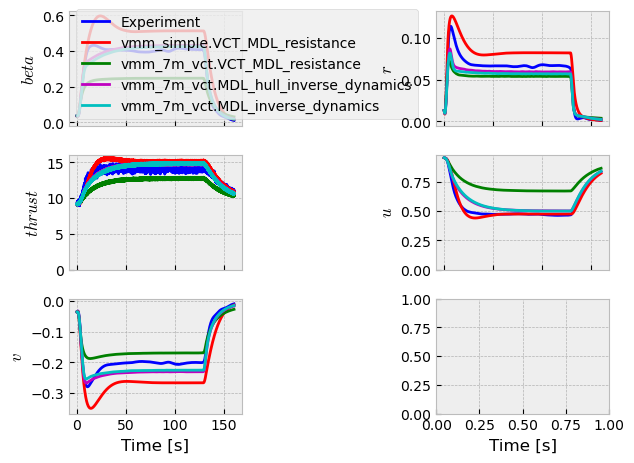

In [5]:
plot(dataframes, keys=['u','v','r','beta','thrust']);

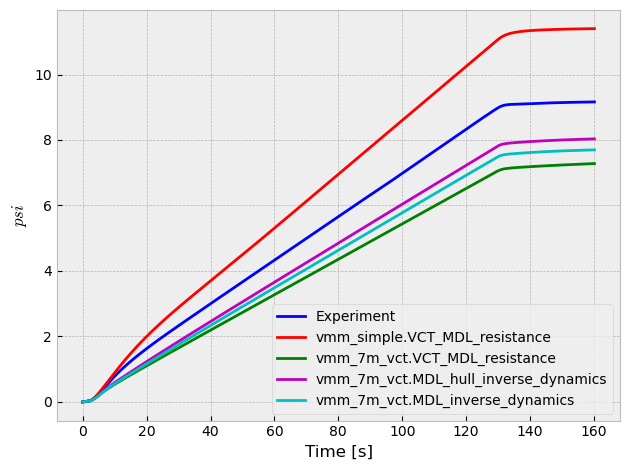

In [6]:
plot(dataframes, keys=['psi'], ncols=1);